In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import wandb
import os, sys
import glob
import numpy as np
import torch
import pandas as pd
import random
import torch.nn as nn
import pickle
import torch.nn.functional as F

In [3]:
from mstcn_model import *
from utility.adaptive_data_loader import Breakfast, collate_fn_override
from utils import calculate_mof, dotdict

In [4]:
os.environ["WANDB_API_KEY"] = "992b3b1371ba79f48484cfca522b3786d7fa52c2"
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: dipika_singhania (use `wandb login --relogin` to force relogin)


True

In [5]:
seed = 42

# Ensure deterministic behavior
def set_seed():
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
set_seed()

# Device configuration
os.environ['CUDA_VISIBLE_DEVICES']='4'
# os.environ['CUDA_LAUNCH_BLOCKING']='6'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
config = dotdict(
    epochs=500,
    num_class=48,
    batch_size=8,
    learning_rate=5e-4,
    weight_decay=0,
    dataset="Breakfast",
    architecture="unet-ensemble",
    features_file_name="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/",
    chunk_size=1,
    max_frames_per_video=1200,
    feature_size=2048,
    ground_truth_files_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/",
    label_id_csv="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv",
    gamma=0.1,
    step_size=500,
    split=3,
#     output_dir="/mnt/data/ar-datasets/dipika/breakfast/ms_tcn/data/breakfast/results/unsuper-finetune-split2-0.05-data-llr/",
    output_dir="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/mstcnnew-full-supervised-split3/",
    project_name="breakfast-split-3",
    train_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split{}.bundle",
    test_split_file="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split{}.bundle",
    all_files="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt",
    cutoff=8,
    data_per = 0.2,
    budget=40,
    semi_supervised_split="/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/semi_supervised/train.split{}_amt{}.bundle")

config.train_split_file = config.train_split_file.format(config.split)
config.semi_supervised_split = config.semi_supervised_split.format(config.split, config.data_per)
config.test_split_file = config.test_split_file.format(config.split)

if not os.path.exists(config.output_dir):
    os.mkdir(config.output_dir)

print(config)

{'epochs': 500, 'num_class': 48, 'batch_size': 8, 'learning_rate': 0.0005, 'weight_decay': 0, 'dataset': 'Breakfast', 'architecture': 'unet-ensemble', 'features_file_name': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/features/', 'chunk_size': 1, 'max_frames_per_video': 1200, 'feature_size': 2048, 'ground_truth_files_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/', 'label_id_csv': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/mapping.csv', 'gamma': 0.1, 'step_size': 500, 'split': 3, 'output_dir': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/mstcnnew-full-supervised-split3/', 'project_name': 'breakfast-split-3', 'train_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/train.split3.bundle', 'test_split_file': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/test.split3.bundle', 'all_files': '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/splits/all_files.txt', 'cutoff': 8, 'data_per': 0.2, 'budget': 40, 'semi_supervised_

In [7]:
traindataset = Breakfast(config, fold='train', fold_file_name=config.train_split_file)
testdataset = Breakfast(config, fold='test', fold_file_name=config.test_split_file)

Number of videos logged in train fold is 1279
Number of videos not found in train fold is 0
Number of videos logged in test fold is 433
Number of videos not found in test fold is 0


In [8]:
def _init_fn(worker_id):
    np.random.seed(int(seed))
trainloader = torch.utils.data.DataLoader(dataset=traindataset,
                                          batch_size=config.batch_size, 
                                          shuffle=True,
                                          pin_memory=True, num_workers=4, 
                                          collate_fn=lambda x: collate_fn_override(x, config.max_frames_per_video),
                                          worker_init_fn=_init_fn)
testloader = torch.utils.data.DataLoader(dataset=testdataset,
                                          batch_size=config.batch_size, 
                                          shuffle=False,
                                          pin_memory=True, num_workers=4,
                                          collate_fn=lambda x: collate_fn_override(x, config.max_frames_per_video),
                                          worker_init_fn=_init_fn)

In [9]:
# item = iter(trainloader).next()
# print(item[0]) # -- data feature
# print(item[1]) # -- valid count
# item[2] # -- Actual labels
# print(item[5]) # video names
# video_id_boundary_frames

In [10]:
loaded_vidid_selected_frames = np.load("/home/dipika16/ar/TimestampActionSeg/data/breakfast_annotation_all.npy", allow_pickle=True).item()
# loaded_vidid_selected_frames
video_id_boundary_frames = pickle.load(open("dump_dir/chunk_1_video_id_boundary_frames_dict.pkl", "rb"))
# video_id_boundary_frames

In [11]:
loaded_mean_var_actions = pickle.load(open("dump_dir/mean_var_actions.pkl", "rb"))
def get_possion_prob(cur_len, cur_class):
    mean_class, std_class = loaded_mean_var_actions[cur_class]
    mean_class = mean_class * 10
    prob = cur_len * torch.log(torch.tensor(mean_class, device=device) + 1e-5)
    prob = prob - mean_class
    factorials = torch.cumsum(torch.log(torch.arange(1, torch.max(cur_len)+1, 1).type(torch.float).to(device)), 
                              dim=0)[min(cur_len)-1:]
    prob = prob - factorials
    return prob

# get_possion_prob(torch.arange(10, 21), 20)

In [12]:
prob_video_each_segment_dict = {}

In [13]:
def prob_vals_per_segment(selected_frames, cur_vid_feat, labels):
    prob_each_segment = []
    
    log_probs = torch.log(cur_vid_feat + 1e-8)
    cumsum_feat = torch.cumsum(log_probs, dim=0)
    cur_boundary = 0
    for i, cur_ele in enumerate(selected_frames[:-1]):

        next_ele = selected_frames[i + 1]
        label_cur_ele = labels[cur_ele]
        label_next_ele = labels[next_ele]

        indices = torch.arange(cur_ele, next_ele).to(cumsum_feat.device)
        strt_index = cumsum_feat[cur_ele - 1, :][None, :] if cur_ele > 0 else 0
        end_index = cumsum_feat[next_ele - 1, :][None, :]
        left_sum = (cumsum_feat[indices, :] - strt_index)[:,label_cur_ele]
        right_sum = (end_index - cumsum_feat[indices, :])[:,label_next_ele]

        cur_boundary_len = indices - cur_boundary
        len_prob = get_possion_prob(cur_boundary_len, label_cur_ele.item())

        prob = torch.softmax((left_sum + right_sum + len_prob), dim=0)
#         prob = torch.softmax((left_sum + right_sum), dim=0)

        cur_boundary = round(np.sum(np.arange(cur_ele, next_ele, 1) * prob.detach().cpu().numpy()).item())
        prob_each_segment.append(prob)
    
    return prob_each_segment

In [14]:
def calculate_element_probb(data_feat, data_count, video_ids, labels_all): #, loaded_vidid_selected_frames, boundaries_dict):
    global prob_video_each_segment_dict, loaded_vidid_selected_frames
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        labels = labels_all[iter_num]
        
        selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
        prob_video = prob_vals_per_segment(selected_frames, cur_vid_feat, labels)
        prob_video_each_segment_dict[cur_vidid] = prob_video

In [15]:
def get_estimated_loss(data_feat, data_count, video_ids, labels_all): #, loaded_vidid_selected_frames, boundaries_dict):
    global prob_video_each_segment_dict, loaded_vidid_selected_frames
    loss_arr = []
    for iter_num in range(len(data_count)):
        cur_vidid = video_ids[iter_num]
        cur_vid_feat = data_feat[iter_num]
        cur_vid_count = data_count[iter_num]
        labels = labels_all[iter_num]
        
        selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
        prob_each_video = prob_video_each_segment_dict[cur_vidid]
        
        log_probs = torch.log(cur_vid_feat + 1e-8)
        cumsum_feat = torch.cumsum(log_probs, dim=0)
        
        
        current_vid_prob_arr = []
        # Start segment log probability
        start_ele_idx = selected_frames[0]
        if start_ele_idx > 0:
            start_ele_label_idx = labels[selected_frames[0]]
            first_segment_prob = (cumsum_feat[start_ele_idx - 1, :])[start_ele_label_idx]
            current_vid_prob_arr.append(first_segment_prob.unsqueeze(0))
        
        for i, cur_ele in enumerate(selected_frames[:-1]):
            next_ele = selected_frames[i + 1]
            label_cur_ele = labels[cur_ele]
            label_next_ele = labels[next_ele]

            indices = torch.arange(cur_ele, next_ele)
            strt_index = cumsum_feat[cur_ele - 1, :][None, :] if cur_ele > 0 else 0
            end_index = cumsum_feat[next_ele - 1, :][None, :]
            left_sum = (cumsum_feat[indices, :] - strt_index)[:,label_cur_ele]
            right_sum = (end_index - cumsum_feat[indices, :])[:,label_next_ele]
            current_vid_prob_arr.append((left_sum + right_sum)  * (prob_each_video[i]))
        
        # End segment log probability
        end_index = cur_vid_count.item() - 1
        last_ele_label_idx = labels[selected_frames[-1]]
        last_segment_sum_prob = (cumsum_feat[end_index, :] - cumsum_feat[selected_frames[-1] - 1, :])[last_ele_label_idx]
        current_vid_prob_arr.append(last_segment_sum_prob.unsqueeze(0))
            
        loss_arr.append(torch.cat(current_vid_prob_arr))
    return -torch.mean(torch.cat(loss_arr)), loss_arr

In [16]:
train_split_file_list = set(open(config.train_split_file).read().split("\n")[0:-1])

def get_estimated_boundaries():
    global prob_video_each_segment_dict, loaded_vidid_selected_frames, video_id_boundary_frames
    estimated_boundary_dict = {}
    for ele in video_id_boundary_frames.keys():
        if (ele + ".txt") not in train_split_file_list:
            continue
        estimated_boundary_probs = prob_video_each_segment_dict[ele]
        selected_ele_list = loaded_vidid_selected_frames[ele + ".txt"]
        boundary_list = []
        for i, segment in enumerate(estimated_boundary_probs):
            estimated_boundary = np.sum(np.arange(selected_ele_list[i], selected_ele_list[i + 1], 1) \
                                        * segment.detach().cpu().numpy())
            estimated_boundary = round(estimated_boundary.item())
            
            if (estimated_boundary < selected_ele_list[i]) or (estimated_boundary > selected_ele_list[i + 1]):
                print("Estimated value wrong")
                import pdb
                pdb.set_trace()
            boundary_list.append(estimated_boundary)

        estimated_boundary_dict[ele] = boundary_list
    return estimated_boundary_dict

In [17]:

def get_boundary_err():
    global prob_video_each_segment_dict, loaded_vidid_selected_frames
    err_list = []
    correct = 0.0
    total = 0.0
    estimated_boundar_dict = get_estimated_boundaries()
    for ele in video_id_boundary_frames.keys():
        if (ele + ".txt") not in train_split_file_list:
            continue
        estimated_boundary_probs = prob_video_each_segment_dict[ele]
        estimated_boundary_list = estimated_boundar_dict[ele]
        
        estimated = np.array(estimated_boundary_list) #.detach().cpu().numpy()
        actual = np.array(video_id_boundary_frames[ele][:-1])
        if len(actual) != len(estimated):
            print(ele)
            continue
        
        mse_err = (actual - estimated)**2
        err_list.append(mse_err)
        
        estimated_labels = []
        actual_labels = []
        start_v1 = 0
        start_v2 = 0
        for i, v1 in enumerate(estimated):
            estimated_labels.extend([i] * (v1 - start_v1))
            start_v1 = v1
            v2 = actual[i]
            actual_labels.extend([i] * (v2 - start_v2))
            start_v2 = v2
            
        last_ele = video_id_boundary_frames[ele][-1]
        estimated_labels.extend([i+1] * (last_ele - start_v1))
        actual_labels.extend([i+1] * (last_ele - start_v2))
        
        correct += np.sum(np.array(actual_labels) == np.array(estimated_labels))
        total += len(actual_labels)
        
    print(f"Train Boundary avergage error = {np.sqrt(np.mean(np.concatenate(err_list))):.3f}")
    print(f"Train From boundary avergage accuracy = {correct * 100.0 / total:.3f}")

In [18]:
set_seed()
model = MultiStageModel(num_stages=4, num_layers=10, num_f_maps=64, dim=2048, num_classes=48).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

# Requires loaded_vidid_selected_frames, boundaries_dict
ce_criterion = nn.CrossEntropyLoss(ignore_index=-100)
mse_criterion = nn.MSELoss(reduction='none')

In [19]:
def get_single_random(labels_all, video_ids):
    # Generate target for only timestamps. Do not generate pseudo labels at first 30 epochs.
    boundary_target_tensor = torch.ones((labels_all.shape[0], labels_all.shape[1]), dtype=torch.long, device=labels_all.device) * (-100)
    for iter_num, labels in enumerate(labels_all):
        cur_vidid = video_ids[iter_num]
        frame_idx_tensor = torch.from_numpy(np.array(loaded_vidid_selected_frames[cur_vidid + ".txt"]))
        boundary_target_tensor[iter_num, frame_idx_tensor] = labels[frame_idx_tensor]

    return boundary_target_tensor

In [20]:
config.output_dir

'/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/mstcnnew-full-supervised-split3/'

In [21]:
initialize_epoch = 15
expectation_cal_gap = 5
best_val_acc = 0
for epoch in range(1000):
    print("Starting Training")
    model.train()
    for i, item in enumerate(trainloader):
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)
        optimizer.zero_grad()
        
        middle_pred, predictions = model(item_0, src_mask_mse)
        
        loss = 0
        for p in predictions:
            loss += ce_criterion(p, item_2)
            loss += 0.15 * torch.mean(torch.clamp(mse_criterion(F.log_softmax(p[:, :, 1:], dim=1), 
                                                                F.log_softmax(p.detach()[:, :, :-1], dim=1)), min=0,
                                        max=16) * src_mask_mse[:, :, 1:])
            

        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:
            with torch.no_grad():
                pred = torch.argmax(predictions[-1], dim=1)
                correct = float(torch.sum((pred == item_2) * src_mask).item())
                total = float(torch.sum(src_mask).item())
                print(f"Training:: Epoch {epoch}, Iteration {i}, Current loss {loss.item()}" +
                      f" Accuracy {correct * 100.0 / total}")
    # Calculating Expectation Step
    model.eval()

    print("Calculating Validation Data Accuracy")
    correct = 0.0
    total = 0.0
    for i, item in enumerate(testloader):
        with torch.no_grad():
            item_0 = item[0].to(device)
            item_1 = item[1].to(device)
            item_2 = item[2].to(device)
            src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
            src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

            middle_pred, predictions = model(item_0, src_mask_mse)

            pred = torch.argmax(predictions[-1], dim=1)
            correct += float(torch.sum((pred == item_2) * src_mask).item())
            total += float(torch.sum(src_mask).item())
    val_acc = correct * 100.0 / total
    if val_acc > best_val_acc:
        torch.save(model.state_dict(), config.output_dir + "ms-tcn-best-model.wt")
    torch.save(model.state_dict(), config.output_dir + "ms-tcn-last-model.wt")
    print(f"Validation:: Epoch {epoch}, Probability Accuracy {val_acc}")

Starting Training
Training:: Epoch 0, Iteration 0, Current loss 15.741896629333496 Accuracy 4.178496481915813
Training:: Epoch 0, Iteration 10, Current loss 15.739640235900879 Accuracy 1.219186615644745
Training:: Epoch 0, Iteration 20, Current loss 14.998711585998535 Accuracy 0.25430244248624995
Training:: Epoch 0, Iteration 30, Current loss 12.849777221679688 Accuracy 9.611134340839854
Training:: Epoch 0, Iteration 40, Current loss 13.779166221618652 Accuracy 8.066712049012933
Training:: Epoch 0, Iteration 50, Current loss 13.135438919067383 Accuracy 14.73735705986669
Training:: Epoch 0, Iteration 60, Current loss 14.933050155639648 Accuracy 3.402646502835539
Training:: Epoch 0, Iteration 70, Current loss 11.373003005981445 Accuracy 10.687778327560613
Training:: Epoch 0, Iteration 80, Current loss 12.752055168151855 Accuracy 10.082075721472068
Training:: Epoch 0, Iteration 90, Current loss 12.322772026062012 Accuracy 8.80356796587163
Training:: Epoch 0, Iteration 100, Current loss 12

Training:: Epoch 5, Iteration 20, Current loss 5.303276062011719 Accuracy 51.250194129523216
Training:: Epoch 5, Iteration 30, Current loss 6.343340873718262 Accuracy 47.31130187252591
Training:: Epoch 5, Iteration 40, Current loss 5.740039348602295 Accuracy 54.85038508480283
Training:: Epoch 5, Iteration 50, Current loss 4.781839847564697 Accuracy 61.09089254844873
Training:: Epoch 5, Iteration 60, Current loss 5.095589637756348 Accuracy 56.36801730920535
Training:: Epoch 5, Iteration 70, Current loss 5.256860256195068 Accuracy 54.55243527863098
Training:: Epoch 5, Iteration 80, Current loss 4.7979278564453125 Accuracy 66.16551298443632
Training:: Epoch 5, Iteration 90, Current loss 7.16542911529541 Accuracy 34.99862210149207
Training:: Epoch 5, Iteration 100, Current loss 4.7020392417907715 Accuracy 52.355575712908895
Training:: Epoch 5, Iteration 110, Current loss 8.194049835205078 Accuracy 33.897572125779945
Training:: Epoch 5, Iteration 120, Current loss 4.88438081741333 Accuracy 

Training:: Epoch 10, Iteration 50, Current loss 3.9355640411376953 Accuracy 72.2707315869962
Training:: Epoch 10, Iteration 60, Current loss 3.374910831451416 Accuracy 75.31279806990966
Training:: Epoch 10, Iteration 70, Current loss 3.2447245121002197 Accuracy 82.34112698472849
Training:: Epoch 10, Iteration 80, Current loss 4.360922336578369 Accuracy 68.07842065714871
Training:: Epoch 10, Iteration 90, Current loss 3.7737386226654053 Accuracy 74.7031583946806
Training:: Epoch 10, Iteration 100, Current loss 5.975279808044434 Accuracy 60.707134275416216
Training:: Epoch 10, Iteration 110, Current loss 3.7115731239318848 Accuracy 77.47585015314537
Training:: Epoch 10, Iteration 120, Current loss 3.866051435470581 Accuracy 75.98610488570148
Training:: Epoch 10, Iteration 130, Current loss 5.121955871582031 Accuracy 67.02725020644095
Training:: Epoch 10, Iteration 140, Current loss 5.151327610015869 Accuracy 67.98685891586055
Training:: Epoch 10, Iteration 150, Current loss 6.26643896102

Training:: Epoch 15, Iteration 70, Current loss 4.08786153793335 Accuracy 73.66295527458011
Training:: Epoch 15, Iteration 80, Current loss 2.8858590126037598 Accuracy 86.14940265196272
Training:: Epoch 15, Iteration 90, Current loss 4.258543014526367 Accuracy 74.13259488516044
Training:: Epoch 15, Iteration 100, Current loss 4.76881742477417 Accuracy 68.07854777942687
Training:: Epoch 15, Iteration 110, Current loss 4.182324409484863 Accuracy 74.2316366691726
Training:: Epoch 15, Iteration 120, Current loss 2.414311170578003 Accuracy 87.94987614745737
Training:: Epoch 15, Iteration 130, Current loss 2.6222593784332275 Accuracy 86.9087332135831
Training:: Epoch 15, Iteration 140, Current loss 2.6966392993927 Accuracy 82.89681495130297
Training:: Epoch 15, Iteration 150, Current loss 3.5905444622039795 Accuracy 77.61215319877327
Calculating Validation Data Accuracy
Validation:: Epoch 15, Probability Accuracy 68.66937126466928
Starting Training
Training:: Epoch 16, Iteration 0, Current l

Training:: Epoch 21, Iteration 40, Current loss 2.0465922355651855 Accuracy 89.54820756261253
Training:: Epoch 21, Iteration 50, Current loss 2.4584708213806152 Accuracy 87.35249811699724
Training:: Epoch 21, Iteration 60, Current loss 2.03971266746521 Accuracy 93.40592861464005
Training:: Epoch 21, Iteration 70, Current loss 2.3759443759918213 Accuracy 87.08311275807306
Training:: Epoch 21, Iteration 80, Current loss 2.2197422981262207 Accuracy 86.59404502541757
Training:: Epoch 21, Iteration 90, Current loss 1.8141175508499146 Accuracy 91.69761020660764
Training:: Epoch 21, Iteration 100, Current loss 3.8604178428649902 Accuracy 82.5051722260535
Training:: Epoch 21, Iteration 110, Current loss 2.2010228633880615 Accuracy 90.60263383910679
Training:: Epoch 21, Iteration 120, Current loss 2.5316483974456787 Accuracy 88.65353280995409
Training:: Epoch 21, Iteration 130, Current loss 2.8823368549346924 Accuracy 87.95591548438166
Training:: Epoch 21, Iteration 140, Current loss 2.14904212

Training:: Epoch 26, Iteration 60, Current loss 2.114187717437744 Accuracy 90.23907304194779
Training:: Epoch 26, Iteration 70, Current loss 1.4691003561019897 Accuracy 94.58144892908952
Training:: Epoch 26, Iteration 80, Current loss 1.36734139919281 Accuracy 92.93736501079914
Training:: Epoch 26, Iteration 90, Current loss 1.587613582611084 Accuracy 95.03942020469125
Training:: Epoch 26, Iteration 100, Current loss 1.9400601387023926 Accuracy 89.19831223628692
Training:: Epoch 26, Iteration 110, Current loss 1.2828283309936523 Accuracy 96.43144350623241
Training:: Epoch 26, Iteration 120, Current loss 1.7997190952301025 Accuracy 93.93901446371548
Training:: Epoch 26, Iteration 130, Current loss 4.263506889343262 Accuracy 78.03580695381422
Training:: Epoch 26, Iteration 140, Current loss 1.730745553970337 Accuracy 93.38096521973578
Training:: Epoch 26, Iteration 150, Current loss 1.4851540327072144 Accuracy 90.61870057373235
Calculating Validation Data Accuracy
Validation:: Epoch 26, 

Training:: Epoch 31, Iteration 80, Current loss 1.0879417657852173 Accuracy 95.44143104443162
Training:: Epoch 31, Iteration 90, Current loss 1.0948883295059204 Accuracy 96.5978214740416
Training:: Epoch 31, Iteration 100, Current loss 1.2713900804519653 Accuracy 94.9972885032538
Training:: Epoch 31, Iteration 110, Current loss 1.4662339687347412 Accuracy 92.97259311314126
Training:: Epoch 31, Iteration 120, Current loss 1.0769336223602295 Accuracy 96.57950530035336
Training:: Epoch 31, Iteration 130, Current loss 1.1850574016571045 Accuracy 96.33352370074243
Training:: Epoch 31, Iteration 140, Current loss 1.450130581855774 Accuracy 95.50144135942952
Training:: Epoch 31, Iteration 150, Current loss 1.1536790132522583 Accuracy 97.1617313822637
Calculating Validation Data Accuracy
Validation:: Epoch 31, Probability Accuracy 70.43108018370434
Starting Training
Training:: Epoch 32, Iteration 0, Current loss 1.8120604753494263 Accuracy 94.37925946743484
Training:: Epoch 32, Iteration 10, C

Training:: Epoch 36, Iteration 100, Current loss 1.4756090641021729 Accuracy 94.75604195166439
Training:: Epoch 36, Iteration 110, Current loss 1.1044081449508667 Accuracy 96.92858488788393
Training:: Epoch 36, Iteration 120, Current loss 1.4383094310760498 Accuracy 95.86848801392794
Training:: Epoch 36, Iteration 130, Current loss 1.2608469724655151 Accuracy 97.35021447350215
Training:: Epoch 36, Iteration 140, Current loss 1.310852289199829 Accuracy 94.84846882107156
Training:: Epoch 36, Iteration 150, Current loss 1.003014087677002 Accuracy 97.67715762612053
Calculating Validation Data Accuracy
Validation:: Epoch 36, Probability Accuracy 69.36590755631944
Starting Training
Training:: Epoch 37, Iteration 0, Current loss 1.178820252418518 Accuracy 96.37867952769001
Training:: Epoch 37, Iteration 10, Current loss 1.5640592575073242 Accuracy 95.8821640712795
Training:: Epoch 37, Iteration 20, Current loss 1.2961276769638062 Accuracy 95.42640186915888
Training:: Epoch 37, Iteration 30, C

Training:: Epoch 41, Iteration 120, Current loss 1.1109238862991333 Accuracy 96.05972898302855
Training:: Epoch 41, Iteration 130, Current loss 1.069351077079773 Accuracy 96.97057126370456
Training:: Epoch 41, Iteration 140, Current loss 0.7799539566040039 Accuracy 97.91770504513485
Training:: Epoch 41, Iteration 150, Current loss 0.952498733997345 Accuracy 98.24421388667199
Calculating Validation Data Accuracy
Validation:: Epoch 41, Probability Accuracy 71.97113855391432
Starting Training
Training:: Epoch 42, Iteration 0, Current loss 1.212652564048767 Accuracy 97.36193570068332
Training:: Epoch 42, Iteration 10, Current loss 1.1413626670837402 Accuracy 97.5458537845518
Training:: Epoch 42, Iteration 20, Current loss 0.9441373944282532 Accuracy 96.38796778777831
Training:: Epoch 42, Iteration 30, Current loss 1.3240259885787964 Accuracy 96.35776855693868
Training:: Epoch 42, Iteration 40, Current loss 1.0760819911956787 Accuracy 97.1911824461601
Training:: Epoch 42, Iteration 50, Curr

Training:: Epoch 46, Iteration 130, Current loss 1.564468502998352 Accuracy 94.6459802538787
Training:: Epoch 46, Iteration 140, Current loss 2.0976459980010986 Accuracy 93.31246442800227
Training:: Epoch 46, Iteration 150, Current loss 2.363323211669922 Accuracy 90.36401187556473
Calculating Validation Data Accuracy
Validation:: Epoch 46, Probability Accuracy 68.12830285545282
Starting Training
Training:: Epoch 47, Iteration 0, Current loss 2.489412307739258 Accuracy 89.25619834710744
Training:: Epoch 47, Iteration 10, Current loss 3.3610332012176514 Accuracy 83.2535885167464
Training:: Epoch 47, Iteration 20, Current loss 3.752472162246704 Accuracy 77.57974215419385
Training:: Epoch 47, Iteration 30, Current loss 2.556938409805298 Accuracy 88.14338964231898
Training:: Epoch 47, Iteration 40, Current loss 1.826987624168396 Accuracy 92.3302036337032
Training:: Epoch 47, Iteration 50, Current loss 1.580244779586792 Accuracy 91.83890712321477
Training:: Epoch 47, Iteration 60, Current lo

Training:: Epoch 51, Iteration 150, Current loss 0.768423318862915 Accuracy 98.79705083430345
Calculating Validation Data Accuracy
Validation:: Epoch 51, Probability Accuracy 72.79803126098626
Starting Training
Training:: Epoch 52, Iteration 0, Current loss 0.5833995342254639 Accuracy 98.55899794934324
Training:: Epoch 52, Iteration 10, Current loss 0.9097919464111328 Accuracy 98.5536107326276
Training:: Epoch 52, Iteration 20, Current loss 1.3583866357803345 Accuracy 97.41059110686618
Training:: Epoch 52, Iteration 30, Current loss 0.601100504398346 Accuracy 98.23374671176249
Training:: Epoch 52, Iteration 40, Current loss 0.9567152261734009 Accuracy 98.54014598540147
Training:: Epoch 52, Iteration 50, Current loss 1.0986524820327759 Accuracy 97.74535809018568
Training:: Epoch 52, Iteration 60, Current loss 0.914095401763916 Accuracy 98.56801909307876
Training:: Epoch 52, Iteration 70, Current loss 1.0406638383865356 Accuracy 97.51672240802675
Training:: Epoch 52, Iteration 80, Curren

Calculating Validation Data Accuracy
Validation:: Epoch 56, Probability Accuracy 69.7128922271639
Starting Training
Training:: Epoch 57, Iteration 0, Current loss 1.2152808904647827 Accuracy 94.90238611713666
Training:: Epoch 57, Iteration 10, Current loss 0.7685920000076294 Accuracy 97.1987835696235
Training:: Epoch 57, Iteration 20, Current loss 1.1178478002548218 Accuracy 93.19371727748691
Training:: Epoch 57, Iteration 30, Current loss 1.6744242906570435 Accuracy 92.23039469594944
Training:: Epoch 57, Iteration 40, Current loss 0.9935207962989807 Accuracy 96.92627556754327
Training:: Epoch 57, Iteration 50, Current loss 0.8486995697021484 Accuracy 97.72788931090614
Training:: Epoch 57, Iteration 60, Current loss 0.9485663175582886 Accuracy 96.14267711358282
Training:: Epoch 57, Iteration 70, Current loss 0.8155182600021362 Accuracy 97.6839451709469
Training:: Epoch 57, Iteration 80, Current loss 1.1151256561279297 Accuracy 96.22493118364137
Training:: Epoch 57, Iteration 90, Curren

Training:: Epoch 62, Iteration 0, Current loss 0.8086600303649902 Accuracy 97.94394024576339
Training:: Epoch 62, Iteration 10, Current loss 1.088794231414795 Accuracy 97.65461763476807
Training:: Epoch 62, Iteration 20, Current loss 0.8428149223327637 Accuracy 97.53246107158847
Training:: Epoch 62, Iteration 30, Current loss 1.3369957208633423 Accuracy 96.30344670944297
Training:: Epoch 62, Iteration 40, Current loss 0.9702346324920654 Accuracy 97.04998844642995
Training:: Epoch 62, Iteration 50, Current loss 0.9663493633270264 Accuracy 96.81089467333219
Training:: Epoch 62, Iteration 60, Current loss 0.675694465637207 Accuracy 97.99392415671485
Training:: Epoch 62, Iteration 70, Current loss 0.8772801160812378 Accuracy 98.05573558003888
Training:: Epoch 62, Iteration 80, Current loss 0.757576048374176 Accuracy 98.132063136266
Training:: Epoch 62, Iteration 90, Current loss 1.0137752294540405 Accuracy 97.43091095189355
Training:: Epoch 62, Iteration 100, Current loss 0.828618645668029

Training:: Epoch 67, Iteration 20, Current loss 0.7774235010147095 Accuracy 98.15136406923982
Training:: Epoch 67, Iteration 30, Current loss 0.7135730385780334 Accuracy 98.90428026971563
Training:: Epoch 67, Iteration 40, Current loss 0.7905089855194092 Accuracy 98.40038778477945
Training:: Epoch 67, Iteration 50, Current loss 0.6289545297622681 Accuracy 99.19945225680729
Training:: Epoch 67, Iteration 60, Current loss 0.7276728749275208 Accuracy 98.84545367442752
Training:: Epoch 67, Iteration 70, Current loss 0.5575238466262817 Accuracy 98.79452054794521
Training:: Epoch 67, Iteration 80, Current loss 0.6413687467575073 Accuracy 99.10041605757337
Training:: Epoch 67, Iteration 90, Current loss 0.8014662861824036 Accuracy 98.7159036528952
Training:: Epoch 67, Iteration 100, Current loss 0.5618925094604492 Accuracy 98.85142951578251
Training:: Epoch 67, Iteration 110, Current loss 0.47065216302871704 Accuracy 99.14260165167535
Training:: Epoch 67, Iteration 120, Current loss 0.5883765

Training:: Epoch 72, Iteration 30, Current loss 0.6824126243591309 Accuracy 98.35782979495555
Training:: Epoch 72, Iteration 40, Current loss 0.6827861666679382 Accuracy 98.6171132238548
Training:: Epoch 72, Iteration 50, Current loss 0.625305712223053 Accuracy 98.6740550168217
Training:: Epoch 72, Iteration 60, Current loss 0.6996022462844849 Accuracy 98.97143828629717
Training:: Epoch 72, Iteration 70, Current loss 0.8036798238754272 Accuracy 98.96781534460338
Training:: Epoch 72, Iteration 80, Current loss 0.5915366411209106 Accuracy 98.92494212735905
Training:: Epoch 72, Iteration 90, Current loss 0.6410714983940125 Accuracy 98.45451519330449
Training:: Epoch 72, Iteration 100, Current loss 0.6835073828697205 Accuracy 98.48214285714286
Training:: Epoch 72, Iteration 110, Current loss 0.7780600786209106 Accuracy 98.33913141061609
Training:: Epoch 72, Iteration 120, Current loss 0.8105496168136597 Accuracy 98.3965917893106
Training:: Epoch 72, Iteration 130, Current loss 0.5709954500

Training:: Epoch 77, Iteration 40, Current loss 1.7124502658843994 Accuracy 92.00760228068421
Training:: Epoch 77, Iteration 50, Current loss 1.5175955295562744 Accuracy 95.79681783374457
Training:: Epoch 77, Iteration 60, Current loss 1.207585096359253 Accuracy 96.54772265738323
Training:: Epoch 77, Iteration 70, Current loss 1.032753586769104 Accuracy 97.82934995958897
Training:: Epoch 77, Iteration 80, Current loss 1.2758774757385254 Accuracy 95.54325836010949
Training:: Epoch 77, Iteration 90, Current loss 1.465200424194336 Accuracy 95.49718574108817
Training:: Epoch 77, Iteration 100, Current loss 1.2561872005462646 Accuracy 95.99261903806811
Training:: Epoch 77, Iteration 110, Current loss 1.2646745443344116 Accuracy 95.54531490015361
Training:: Epoch 77, Iteration 120, Current loss 1.1198588609695435 Accuracy 96.78767007282786
Training:: Epoch 77, Iteration 130, Current loss 1.0965476036071777 Accuracy 96.47289353363814
Training:: Epoch 77, Iteration 140, Current loss 0.97415709

Training:: Epoch 82, Iteration 50, Current loss 0.5536450147628784 Accuracy 98.96366083445491
Training:: Epoch 82, Iteration 60, Current loss 0.7119664549827576 Accuracy 98.9650919620355
Training:: Epoch 82, Iteration 70, Current loss 0.6145573854446411 Accuracy 98.8760631834751
Training:: Epoch 82, Iteration 80, Current loss 0.5503330230712891 Accuracy 99.08062628851619
Training:: Epoch 82, Iteration 90, Current loss 0.7821388840675354 Accuracy 98.8243805389763
Training:: Epoch 82, Iteration 100, Current loss 0.5953540205955505 Accuracy 98.53059043547957
Training:: Epoch 82, Iteration 110, Current loss 0.4972429573535919 Accuracy 99.19422676760969
Training:: Epoch 82, Iteration 120, Current loss 0.4959011971950531 Accuracy 99.21604375569736
Training:: Epoch 82, Iteration 130, Current loss 0.6762685775756836 Accuracy 98.32470716426042
Training:: Epoch 82, Iteration 140, Current loss 0.6277530789375305 Accuracy 98.9167656719547
Training:: Epoch 82, Iteration 150, Current loss 0.60367608

Training:: Epoch 87, Iteration 60, Current loss 0.5921062231063843 Accuracy 98.82795851683478
Training:: Epoch 87, Iteration 70, Current loss 0.5129291415214539 Accuracy 99.30859261110417
Training:: Epoch 87, Iteration 80, Current loss 0.5126921534538269 Accuracy 99.41126997476871
Training:: Epoch 87, Iteration 90, Current loss 0.37108314037323 Accuracy 99.1998254164545
Training:: Epoch 87, Iteration 100, Current loss 0.5385362505912781 Accuracy 98.69121561668146
Training:: Epoch 87, Iteration 110, Current loss 0.43327194452285767 Accuracy 99.17128718774221
Training:: Epoch 87, Iteration 120, Current loss 0.5601201057434082 Accuracy 99.20113616190307
Training:: Epoch 87, Iteration 130, Current loss 0.39784157276153564 Accuracy 99.025069637883
Training:: Epoch 87, Iteration 140, Current loss 0.39798495173454285 Accuracy 99.2347329217897
Training:: Epoch 87, Iteration 150, Current loss 0.6263027191162109 Accuracy 98.99633067127131
Calculating Validation Data Accuracy
Validation:: Epoch 8

Training:: Epoch 92, Iteration 70, Current loss 0.7440786957740784 Accuracy 98.0291759250314
Training:: Epoch 92, Iteration 80, Current loss 1.413214921951294 Accuracy 91.72798677139313
Training:: Epoch 92, Iteration 90, Current loss 0.8258844614028931 Accuracy 98.46821705426356
Training:: Epoch 92, Iteration 100, Current loss 0.7697249054908752 Accuracy 98.07975159339762
Training:: Epoch 92, Iteration 110, Current loss 0.9111712574958801 Accuracy 96.68819129211687
Training:: Epoch 92, Iteration 120, Current loss 0.7621256709098816 Accuracy 98.16666666666667
Training:: Epoch 92, Iteration 130, Current loss 0.7164638638496399 Accuracy 97.96778049752376
Training:: Epoch 92, Iteration 140, Current loss 0.5024830102920532 Accuracy 98.78563610778131
Training:: Epoch 92, Iteration 150, Current loss 0.6874484419822693 Accuracy 98.37606133047564
Calculating Validation Data Accuracy
Validation:: Epoch 92, Probability Accuracy 73.24680107811898
Starting Training
Training:: Epoch 93, Iteration 0,

Training:: Epoch 97, Iteration 80, Current loss 0.7333576679229736 Accuracy 99.13974383483081
Training:: Epoch 97, Iteration 90, Current loss 0.6296099424362183 Accuracy 98.79559770194504
Training:: Epoch 97, Iteration 100, Current loss 0.4364111125469208 Accuracy 99.17715392061956
Training:: Epoch 97, Iteration 110, Current loss 0.5833075046539307 Accuracy 99.04528241506213
Training:: Epoch 97, Iteration 120, Current loss 0.5872718691825867 Accuracy 99.1267727751285
Training:: Epoch 97, Iteration 130, Current loss 0.6105779409408569 Accuracy 99.05702077501105
Training:: Epoch 97, Iteration 140, Current loss 0.5780901312828064 Accuracy 99.23918618567276
Training:: Epoch 97, Iteration 150, Current loss 0.5356330871582031 Accuracy 99.42071304102105
Calculating Validation Data Accuracy
Validation:: Epoch 97, Probability Accuracy 72.52772026941814
Starting Training
Training:: Epoch 98, Iteration 0, Current loss 0.6064478754997253 Accuracy 99.20452166631777
Training:: Epoch 98, Iteration 10

Training:: Epoch 102, Iteration 90, Current loss 0.43368104100227356 Accuracy 99.449786854367
Training:: Epoch 102, Iteration 100, Current loss 0.5474727153778076 Accuracy 98.48211848211848
Training:: Epoch 102, Iteration 110, Current loss 0.3846713900566101 Accuracy 99.4938775510204
Training:: Epoch 102, Iteration 120, Current loss 0.46683403849601746 Accuracy 99.10637297170182
Training:: Epoch 102, Iteration 130, Current loss 0.5805294513702393 Accuracy 99.31158489596712
Training:: Epoch 102, Iteration 140, Current loss 0.4725301265716553 Accuracy 99.17009693267826
Training:: Epoch 102, Iteration 150, Current loss 0.39648672938346863 Accuracy 99.36825627550735
Calculating Validation Data Accuracy
Validation:: Epoch 102, Probability Accuracy 71.33855279825447
Starting Training
Training:: Epoch 103, Iteration 0, Current loss 0.3868941068649292 Accuracy 99.35738372462939
Training:: Epoch 103, Iteration 10, Current loss 0.6136025190353394 Accuracy 99.52899014463074
Training:: Epoch 103, 

Training:: Epoch 107, Iteration 90, Current loss 6.018483638763428 Accuracy 68.34957067371202
Training:: Epoch 107, Iteration 100, Current loss 4.259667873382568 Accuracy 60.92681984939178
Training:: Epoch 107, Iteration 110, Current loss 7.621645927429199 Accuracy 47.889888012357254
Training:: Epoch 107, Iteration 120, Current loss 3.610586166381836 Accuracy 77.18524889796797
Training:: Epoch 107, Iteration 130, Current loss 3.153897523880005 Accuracy 83.78521845651287
Training:: Epoch 107, Iteration 140, Current loss 2.1978704929351807 Accuracy 85.59985268391492
Training:: Epoch 107, Iteration 150, Current loss 2.4146037101745605 Accuracy 85.68080235473673
Calculating Validation Data Accuracy
Validation:: Epoch 107, Probability Accuracy 70.208871602279
Starting Training
Training:: Epoch 108, Iteration 0, Current loss 1.950533390045166 Accuracy 92.47809481015503
Training:: Epoch 108, Iteration 10, Current loss 1.4203135967254639 Accuracy 96.69197870297634
Training:: Epoch 108, Iterati

Training:: Epoch 112, Iteration 100, Current loss 0.6354223489761353 Accuracy 98.92703862660944
Training:: Epoch 112, Iteration 110, Current loss 0.42636141180992126 Accuracy 99.36370063629937
Training:: Epoch 112, Iteration 120, Current loss 0.6466131806373596 Accuracy 98.88522751174368
Training:: Epoch 112, Iteration 130, Current loss 0.46119821071624756 Accuracy 99.4311316955296
Training:: Epoch 112, Iteration 140, Current loss 0.4959915280342102 Accuracy 99.2893766303859
Training:: Epoch 112, Iteration 150, Current loss 0.5474108457565308 Accuracy 99.32862498910106
Calculating Validation Data Accuracy
Validation:: Epoch 112, Probability Accuracy 73.81186488914682
Starting Training
Training:: Epoch 113, Iteration 0, Current loss 0.5803200006484985 Accuracy 99.1034694504145
Training:: Epoch 113, Iteration 10, Current loss 0.39496487379074097 Accuracy 99.43280034572169
Training:: Epoch 113, Iteration 20, Current loss 0.4212060272693634 Accuracy 99.33115413628363
Training:: Epoch 113, 

Training:: Epoch 117, Iteration 100, Current loss 0.545184850692749 Accuracy 99.02174730980511
Training:: Epoch 117, Iteration 110, Current loss 0.44303470849990845 Accuracy 99.43233131208876
Training:: Epoch 117, Iteration 120, Current loss 0.44293007254600525 Accuracy 99.28571428571429
Training:: Epoch 117, Iteration 130, Current loss 0.4102137088775635 Accuracy 99.43972528465571
Training:: Epoch 117, Iteration 140, Current loss 0.5463773012161255 Accuracy 99.35506275735476
Training:: Epoch 117, Iteration 150, Current loss 0.5152355432510376 Accuracy 99.40265262731599
Calculating Validation Data Accuracy
Validation:: Epoch 117, Probability Accuracy 72.52816669549836
Starting Training
Training:: Epoch 118, Iteration 0, Current loss 0.30324283242225647 Accuracy 99.42806209611528
Training:: Epoch 118, Iteration 10, Current loss 0.46691009402275085 Accuracy 99.48920955178139
Training:: Epoch 118, Iteration 20, Current loss 0.4578947126865387 Accuracy 99.28623057462956
Training:: Epoch 11

Training:: Epoch 122, Iteration 100, Current loss 0.42942705750465393 Accuracy 99.06386701662292
Training:: Epoch 122, Iteration 110, Current loss 0.2811667323112488 Accuracy 99.54638957750936
Training:: Epoch 122, Iteration 120, Current loss 0.523615837097168 Accuracy 99.24899381768391
Training:: Epoch 122, Iteration 130, Current loss 0.32860004901885986 Accuracy 99.34764617107248
Training:: Epoch 122, Iteration 140, Current loss 0.5331856608390808 Accuracy 98.96098604461648
Training:: Epoch 122, Iteration 150, Current loss 0.3738378584384918 Accuracy 99.16552996870738
Calculating Validation Data Accuracy
Validation:: Epoch 122, Probability Accuracy 73.1128732540555
Starting Training
Training:: Epoch 123, Iteration 0, Current loss 0.40330564975738525 Accuracy 99.20470977070853
Training:: Epoch 123, Iteration 10, Current loss 0.5396700501441956 Accuracy 99.12697535639298
Training:: Epoch 123, Iteration 20, Current loss 0.5106887817382812 Accuracy 99.14863144493953
Training:: Epoch 123,

Training:: Epoch 127, Iteration 100, Current loss 0.34524762630462646 Accuracy 99.42769402568398
Training:: Epoch 127, Iteration 110, Current loss 0.44502583146095276 Accuracy 99.05417675544794
Training:: Epoch 127, Iteration 120, Current loss 0.4517441391944885 Accuracy 99.02969714789768
Training:: Epoch 127, Iteration 130, Current loss 0.3732043504714966 Accuracy 99.26264326360503
Training:: Epoch 127, Iteration 140, Current loss 0.386974960565567 Accuracy 99.42771084337349
Training:: Epoch 127, Iteration 150, Current loss 0.38721543550491333 Accuracy 99.41198786039453
Calculating Validation Data Accuracy
Validation:: Epoch 127, Probability Accuracy 71.91846027644935
Starting Training
Training:: Epoch 128, Iteration 0, Current loss 0.40469104051589966 Accuracy 99.33654221412775
Training:: Epoch 128, Iteration 10, Current loss 0.3130948841571808 Accuracy 99.37834069254009
Training:: Epoch 128, Iteration 20, Current loss 0.42414966225624084 Accuracy 99.33279321355383
Training:: Epoch 1

Training:: Epoch 132, Iteration 100, Current loss 1.159472107887268 Accuracy 95.44454225352112
Training:: Epoch 132, Iteration 110, Current loss 1.455166220664978 Accuracy 94.06536907822255
Training:: Epoch 132, Iteration 120, Current loss 1.2079472541809082 Accuracy 96.000546000546
Training:: Epoch 132, Iteration 130, Current loss 1.5510269403457642 Accuracy 93.83033419023137
Training:: Epoch 132, Iteration 140, Current loss 1.0414824485778809 Accuracy 96.9332098384275
Training:: Epoch 132, Iteration 150, Current loss 0.9557971358299255 Accuracy 98.32219536470923
Calculating Validation Data Accuracy
Validation:: Epoch 132, Probability Accuracy 68.16323569622938
Starting Training
Training:: Epoch 133, Iteration 0, Current loss 0.9155832529067993 Accuracy 96.23957434570032
Training:: Epoch 133, Iteration 10, Current loss 0.8322080373764038 Accuracy 97.75886955861125
Training:: Epoch 133, Iteration 20, Current loss 1.30800199508667 Accuracy 97.57869249394673
Training:: Epoch 133, Iterati

Training:: Epoch 137, Iteration 100, Current loss 0.3521747589111328 Accuracy 99.40105966367196
Training:: Epoch 137, Iteration 110, Current loss 0.522821843624115 Accuracy 98.97039180765806
Training:: Epoch 137, Iteration 120, Current loss 0.3872477114200592 Accuracy 99.39404584174936
Training:: Epoch 137, Iteration 130, Current loss 0.5022852420806885 Accuracy 99.18957011980268
Training:: Epoch 137, Iteration 140, Current loss 0.5614808201789856 Accuracy 99.24895345973898
Training:: Epoch 137, Iteration 150, Current loss 0.42939382791519165 Accuracy 99.2272234273319
Calculating Validation Data Accuracy
Validation:: Epoch 137, Probability Accuracy 72.80037499790738
Starting Training
Training:: Epoch 138, Iteration 0, Current loss 0.4617418944835663 Accuracy 99.41870810842873
Training:: Epoch 138, Iteration 10, Current loss 0.5849484801292419 Accuracy 99.3665913777865
Training:: Epoch 138, Iteration 20, Current loss 0.42600807547569275 Accuracy 99.4404476418865
Training:: Epoch 138, It

Training:: Epoch 142, Iteration 100, Current loss 0.5655264258384705 Accuracy 99.17059377945334
Training:: Epoch 142, Iteration 110, Current loss 0.3932247757911682 Accuracy 99.40796842498267
Training:: Epoch 142, Iteration 120, Current loss 0.49893996119499207 Accuracy 99.47322756569162
Training:: Epoch 142, Iteration 130, Current loss 0.41727471351623535 Accuracy 99.317738791423
Training:: Epoch 142, Iteration 140, Current loss 0.4756150543689728 Accuracy 99.36555224539336
Training:: Epoch 142, Iteration 150, Current loss 0.3907509744167328 Accuracy 99.35629224332153
Calculating Validation Data Accuracy
Validation:: Epoch 142, Probability Accuracy 71.87671943794956
Starting Training
Training:: Epoch 143, Iteration 0, Current loss 0.3176540434360504 Accuracy 99.48139435414885
Training:: Epoch 143, Iteration 10, Current loss 0.3159729242324829 Accuracy 99.43098542977843
Training:: Epoch 143, Iteration 20, Current loss 0.3242344558238983 Accuracy 99.52825504022246
Training:: Epoch 143, 

Training:: Epoch 147, Iteration 100, Current loss 0.5253686308860779 Accuracy 99.20566260322454
Training:: Epoch 147, Iteration 110, Current loss 0.3983810245990753 Accuracy 98.86949499968942
Training:: Epoch 147, Iteration 120, Current loss 0.41739991307258606 Accuracy 99.1405497517967
Training:: Epoch 147, Iteration 130, Current loss 0.38643404841423035 Accuracy 99.0420658059142
Training:: Epoch 147, Iteration 140, Current loss 0.39793661236763 Accuracy 99.1461879481145
Training:: Epoch 147, Iteration 150, Current loss 0.6257629990577698 Accuracy 97.17022031293106
Calculating Validation Data Accuracy
Validation:: Epoch 147, Probability Accuracy 70.0628902740498
Starting Training
Training:: Epoch 148, Iteration 0, Current loss 0.39311397075653076 Accuracy 99.00804661487237
Training:: Epoch 148, Iteration 10, Current loss 0.5476323366165161 Accuracy 98.67229402971951
Training:: Epoch 148, Iteration 20, Current loss 0.45328348875045776 Accuracy 98.98185438255125
Training:: Epoch 148, It

Training:: Epoch 152, Iteration 100, Current loss 0.32827332615852356 Accuracy 99.4842903575298
Training:: Epoch 152, Iteration 110, Current loss 0.3507588505744934 Accuracy 99.37712101035268
Training:: Epoch 152, Iteration 120, Current loss 0.4056452810764313 Accuracy 98.85816634949066
Training:: Epoch 152, Iteration 130, Current loss 0.5039398074150085 Accuracy 99.45327102803738
Training:: Epoch 152, Iteration 140, Current loss 0.37982437014579773 Accuracy 99.43756422043157
Training:: Epoch 152, Iteration 150, Current loss 0.6274574995040894 Accuracy 99.02490249024902
Calculating Validation Data Accuracy
Validation:: Epoch 152, Probability Accuracy 71.11243798862729
Starting Training
Training:: Epoch 153, Iteration 0, Current loss 0.49892204999923706 Accuracy 98.93543161305253
Training:: Epoch 153, Iteration 10, Current loss 0.3196718990802765 Accuracy 99.58806640868805
Training:: Epoch 153, Iteration 20, Current loss 0.37136906385421753 Accuracy 99.506711024435
Training:: Epoch 153,

Training:: Epoch 157, Iteration 100, Current loss 0.5682530403137207 Accuracy 98.65765683499224
Training:: Epoch 157, Iteration 110, Current loss 0.44959989190101624 Accuracy 99.36696627041654
Training:: Epoch 157, Iteration 120, Current loss 0.5619943141937256 Accuracy 99.23346473937801
Training:: Epoch 157, Iteration 130, Current loss 0.5267006158828735 Accuracy 99.13269731136167
Training:: Epoch 157, Iteration 140, Current loss 0.5986085534095764 Accuracy 99.17287014061208
Training:: Epoch 157, Iteration 150, Current loss 0.5381394028663635 Accuracy 99.09127051740785
Calculating Validation Data Accuracy
Validation:: Epoch 157, Probability Accuracy 73.64914258290969
Starting Training
Training:: Epoch 158, Iteration 0, Current loss 0.3666696846485138 Accuracy 99.45125297237973
Training:: Epoch 158, Iteration 10, Current loss 0.3873249888420105 Accuracy 99.15912855140782
Training:: Epoch 158, Iteration 20, Current loss 0.5375040769577026 Accuracy 99.2442748091603
Training:: Epoch 158, 

Training:: Epoch 162, Iteration 100, Current loss 0.4282940924167633 Accuracy 99.35253590105421
Training:: Epoch 162, Iteration 110, Current loss 0.39778372645378113 Accuracy 99.43178346673184
Training:: Epoch 162, Iteration 120, Current loss 0.32245486974716187 Accuracy 99.48538493207082
Training:: Epoch 162, Iteration 130, Current loss 0.3552052676677704 Accuracy 99.43136945190334
Training:: Epoch 162, Iteration 140, Current loss 0.35016822814941406 Accuracy 99.55976115777756
Training:: Epoch 162, Iteration 150, Current loss 0.39070838689804077 Accuracy 99.32449337002753
Calculating Validation Data Accuracy
Validation:: Epoch 162, Probability Accuracy 72.5799521208029
Starting Training
Training:: Epoch 163, Iteration 0, Current loss 0.44945836067199707 Accuracy 99.16066395239586
Training:: Epoch 163, Iteration 10, Current loss 0.4431230425834656 Accuracy 99.50229461573267
Training:: Epoch 163, Iteration 20, Current loss 0.3640705347061157 Accuracy 99.52611982398736
Training:: Epoch 1

Training:: Epoch 167, Iteration 100, Current loss 0.3259432315826416 Accuracy 99.4701260734515
Training:: Epoch 167, Iteration 110, Current loss 0.3366253972053528 Accuracy 99.50710900473933
Training:: Epoch 167, Iteration 120, Current loss 0.2855475842952728 Accuracy 99.5761347784097
Training:: Epoch 167, Iteration 130, Current loss 0.2809855043888092 Accuracy 99.5333433689598
Training:: Epoch 167, Iteration 140, Current loss 0.41337642073631287 Accuracy 99.2021022455805
Training:: Epoch 167, Iteration 150, Current loss 0.38925936818122864 Accuracy 99.2566844919786
Calculating Validation Data Accuracy
Validation:: Epoch 167, Probability Accuracy 71.94245567826073
Starting Training
Training:: Epoch 168, Iteration 0, Current loss 0.2587372064590454 Accuracy 99.4105676794611
Training:: Epoch 168, Iteration 10, Current loss 0.2955576777458191 Accuracy 99.47586958001497
Training:: Epoch 168, Iteration 20, Current loss 0.34278222918510437 Accuracy 99.30766935243211
Training:: Epoch 168, Ite

Training:: Epoch 172, Iteration 100, Current loss 0.4876995384693146 Accuracy 99.23008706868752
Training:: Epoch 172, Iteration 110, Current loss 0.3490484058856964 Accuracy 99.40623738975039
Training:: Epoch 172, Iteration 120, Current loss 0.28614962100982666 Accuracy 99.452183440288
Training:: Epoch 172, Iteration 130, Current loss 0.4253469407558441 Accuracy 99.37574711117014
Training:: Epoch 172, Iteration 140, Current loss 0.31208091974258423 Accuracy 99.19508946667439
Training:: Epoch 172, Iteration 150, Current loss 0.3941287100315094 Accuracy 99.21964103487605
Calculating Validation Data Accuracy
Validation:: Epoch 172, Probability Accuracy 70.92929168922048
Starting Training
Training:: Epoch 173, Iteration 0, Current loss 0.2557219862937927 Accuracy 99.5456165359943
Training:: Epoch 173, Iteration 10, Current loss 0.40839117765426636 Accuracy 98.96882684223051
Training:: Epoch 173, Iteration 20, Current loss 0.4062783718109131 Accuracy 99.3182486041728
Training:: Epoch 173, I

Training:: Epoch 177, Iteration 110, Current loss 0.3778083920478821 Accuracy 99.14903583417909
Training:: Epoch 177, Iteration 120, Current loss 0.4313381016254425 Accuracy 99.15611814345992
Training:: Epoch 177, Iteration 130, Current loss 0.5668166875839233 Accuracy 98.79720003943606
Training:: Epoch 177, Iteration 140, Current loss 0.5075043439865112 Accuracy 99.12109951041114
Training:: Epoch 177, Iteration 150, Current loss 0.3889157176017761 Accuracy 99.52609024451726
Calculating Validation Data Accuracy
Validation:: Epoch 177, Probability Accuracy 73.41577334947908
Starting Training
Training:: Epoch 178, Iteration 0, Current loss 0.46800294518470764 Accuracy 99.36475853605717
Training:: Epoch 178, Iteration 10, Current loss 0.7055591344833374 Accuracy 99.09401867430896
Training:: Epoch 178, Iteration 20, Current loss 0.5195679068565369 Accuracy 98.95917659303805
Training:: Epoch 178, Iteration 30, Current loss 0.49303364753723145 Accuracy 99.0340909090909
Training:: Epoch 178, 

Training:: Epoch 182, Iteration 110, Current loss 0.38164934515953064 Accuracy 99.44311853619729
Training:: Epoch 182, Iteration 120, Current loss 0.4920888841152191 Accuracy 99.47584519961562
Training:: Epoch 182, Iteration 130, Current loss 0.4006948471069336 Accuracy 99.44397817876626
Training:: Epoch 182, Iteration 140, Current loss 0.3306970000267029 Accuracy 99.36086921786371
Training:: Epoch 182, Iteration 150, Current loss 0.3696425259113312 Accuracy 99.35961459373715
Calculating Validation Data Accuracy
Validation:: Epoch 182, Probability Accuracy 72.29490906858778
Starting Training
Training:: Epoch 183, Iteration 0, Current loss 0.44171375036239624 Accuracy 99.29093138561603
Training:: Epoch 183, Iteration 10, Current loss 0.4500977396965027 Accuracy 99.57981040225468
Training:: Epoch 183, Iteration 20, Current loss 0.39740481972694397 Accuracy 99.3627582506037
Training:: Epoch 183, Iteration 30, Current loss 0.2559404671192169 Accuracy 99.52308944980807
Training:: Epoch 183,

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Training:: Epoch 187, Iteration 110, Current loss 0.4555128216743469 Accuracy 99.39260563380282
Training:: Epoch 187, Iteration 120, Current loss 0.38715529441833496 Accuracy 99.50753708485976
Training:: Epoch 187, Iteration 130, Current loss 0.46430540084838867 Accuracy 99.40633245382585
Training:: Epoch 187, Iteration 140, Current loss 0.3018034100532532 Accuracy 99.46796553016111
Training:: Epoch 187, Iteration 150, Current loss 0.41861453652381897 Accuracy 99.35201851375675
Calculating Validation Data Accuracy
Validation:: Epoch 187, Probability Accuracy 71.61544857450572
Starting Training
Training:: Epoch 188, Iteration 0, Current loss 0.4354614019393921 Accuracy 99.5981220657277
Training:: Epoch 188, Iteration 10, Current loss 0.33277326822280884 Accuracy 99.48073701842546
Training:: Epoch 188, Iteration 20, Current loss 0.5041451454162598 Accuracy 99.33454325468844
Training:: Epoch 188, Iteration 30, Current loss 0.2775978744029999 Accuracy 99.60788973384031
Training:: Epoch 188

KeyboardInterrupt: 

In [24]:
!ls '/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-split3/ms-tcn-initial-15-epochs.wt'


/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-split3/ms-tcn-initial-15-epochs.wt


In [24]:
torch.save(model.state_dict(),
"/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-speed/final-em-maximized.wt")

In [34]:
model.load_state_dict(torch.load(f"/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast//results/em-maximize-mstcn-split3/ms-tcn-initial-15-epochs.wt"))

<All keys matched successfully>

In [25]:
print("Calculating Validation Data Accuracy")
correct = 0.0
total = 0.0
for i, item in enumerate(testloader):
    with torch.no_grad():
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

        middle_pred, predictions = model(item_0, src_mask_mse)

        pred = torch.argmax(predictions[-1], dim=1)
        correct += float(torch.sum((pred == item_2) * src_mask).item())
        total += float(torch.sum(src_mask).item())

print(f"Validation:: Epoch {epoch}, Probability Accuracy {correct * 100.0 / total}")

Calculating Validation Data Accuracy
Validation:: Epoch 15, Probability Accuracy 57.770101729343025


In [ ]:
def get_selected_labels(labels_arr):
    unique_ids = []
    
    prev_ele = None
    start = 0
    for i, ele in enumerate(labels_arr):
        if prev_ele is not None and prev_ele != ele:
            select_item = np.random.randint(start, i, 1)[0]
            unique_ids.append(select_item)
            start = i
        prev_ele = ele
    
    select_item = np.random.randint(start, len(labels_arr), 1)[0]
    unique_ids.append(select_item)
    return unique_ids
# get_selected_labels(ab)

In [4]:
def get_boundary(labels_arr):
    unique_ids = []
    
    prev_ele = None
    start = 0
    for i, ele in enumerate(labels_arr):
        if prev_ele is not None and prev_ele != ele:
            unique_ids.append(i - 1)
            start = i
        prev_ele = ele
    
    unique_ids.append(len(labels_arr) - 1)
    return unique_ids
# get_boundary(np.array([2, 2, 2, 2, 3, 3, 4, 4, 4, 1, 1, 1, 1]))

In [6]:
import glob
import numpy as np
boundary_dict = {}
for file in glob.glob("/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/groundTruth/*txt"):
    video_id = file.split("/")[-1].split(".txt")[0]
    data = open(file).read().split("\n")[0:-1]
    data = np.array(data)
    boundary = get_boundary(data)
    boundary_dict[video_id] = boundary
    

In [ ]:
loaded_vidid_selected_frames = {}
for batch in trainloader:
    count_all = batch[1]
    labels_all = batch[2]
    video_ids = batch[5]
    for i, count in enumerate(count_all):
        video_id = video_ids[i]
        labels = labels_all[i][:count]
        selected_ids = get_selected_labels(labels)

        loaded_vidid_selected_frames[video_id] = selected_ids

In [29]:
video_id_boundary_frames = {}
for batch in trainloader:
    count_all = batch[1]
    labels_all = batch[2]
    video_ids = batch[4]
    for i, count in enumerate(count_all):
        
        labels = labels_all[i][:count]
        selected_ids = get_boundary(labels)
        video_id = video_ids[i]
        video_id_boundary_frames[video_id] = selected_ids

In [34]:
for ele in video_id_boundary_frames.keys():
    if len(video_id_boundary_frames[ele]) != len(loaded_vidid_selected_frames[ele + ".txt"]):
        print(ele)

In [9]:
import pickle
# pickle.dump(video_id_boundary_frames, open("dump_dir/video_id_boundary_frames_dict.pkl", "wb"))
# pickle.dump(loaded_vidid_selected_frames, open("dump_dir/loaded_vidid_selected_frames_dict.pkl", "wb"))
pickle.dump(boundary_dict, open("dump_dir/chunk_1_video_id_boundary_frames_dict.pkl", "wb"))

In [ ]:
def get_ensemble_out(outp):
    
    weights = [1, 1, 1, 1, 0, 0]
    ensemble_prob = F.softmax(outp[0], dim=1) * weights[0] / sum(weights)

    for i, outp_ele in enumerate(outp[1]):
        upped_logit = F.upsample(outp_ele, size=outp[0].shape[-1], mode='linear', align_corners=True)
        ensemble_prob = ensemble_prob + F.softmax(upped_logit, dim=1) * weights[i + 1] / sum(weights)
    
    return ensemble_prob

In [ ]:
model.load_state_dict(torch.load('/mnt/ssd/all_users/dipika/ms_tcn/data/breakfast/results/c2f-tcn-model/split2_c2ftcn_model.wt'))

In [76]:
model.eval()
for i, item in enumerate(trainloader):
    with torch.no_grad():
        item_0 = item[0].to(device)
        item_1 = item[1].to(device)
        item_2 = item[2].to(device)
        src_mask = torch.arange(item_2.shape[1], device=item_2.device)[None, :] < item_1[:, None]
        src_mask_mse = src_mask.unsqueeze(1).to(torch.float32).to(device)

        middle_pred, predictions = model(item_0, src_mask_mse)
        prob = torch.softmax(predictions[-1], dim=1)
        prob = prob.permute(0, 2, 1)
        calculate_element_probb(prob, item_1, item[4], item_2)

        if i%10==0:
            print(f'{i+1} iteration done')
get_boundary_err()

1 iteration done
11 iteration done
21 iteration done
31 iteration done
41 iteration done
51 iteration done
61 iteration done
71 iteration done
81 iteration done
91 iteration done
101 iteration done
111 iteration done
121 iteration done
131 iteration done
141 iteration done
151 iteration done
Train Boundary avergage error = 107.269
Train From boundary avergage accuracy = 87.407


In [77]:
with torch.no_grad():
    idx = 4

    cur_vid_feat = torch.softmax(predictions[-1], dim=1).permute(0, 2, 1)[idx]
    cur_vidid = item[4][idx]

    selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
    
    bound_list = video_id_boundary_frames[cur_vidid]
    
    cumsum_feat = torch.cumsum(cur_vid_feat, dim=0)
    prob_each_segment = prob_vals_per_segment(selected_frames, cur_vid_feat, item_2[idx])


Min prob 0 = 7.953912266787591e-36
Min prob 1 = 2.7495868628582206e-249
Min prob 2 = 8.185175464823537e-201


(0, 442)

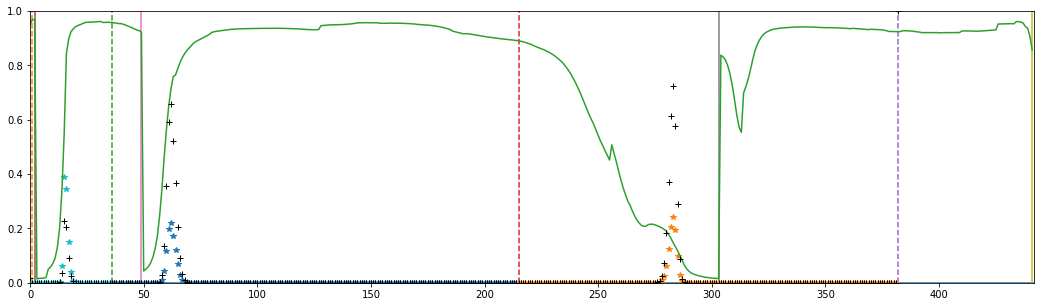

In [78]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(18, 5))

ymax = 1
selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]

plt.plot([0, item[1][idx].item()], [0, 0])

for pivot in loaded_vidid_selected_frames[cur_vidid + ".txt"]:
    plt.plot([pivot, pivot], [0, ymax], '--')
    
for pivot in video_id_boundary_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, ymax])
    
all_prob = []
for i, segment in enumerate(prob_each_segment):
    segment = segment.cpu().numpy()
    print(f"Min prob {i} = {np.min(segment).item()}")
    xs = np.arange(loaded_vidid_selected_frames[cur_vidid + ".txt"][i], 
                   loaded_vidid_selected_frames[cur_vidid + ".txt"][i+1])
    plt.plot(xs, segment, '*')

    
plt_arr = []
for i in range(item[1][idx].item()):
    plt_arr.append(cur_vid_feat[i,item[2][idx][i]].item()) 
plt.plot(np.arange(item[1][idx].item()), plt_arr)


loss_prob = torch.softmax(cur_vid_feat.unsqueeze(0), dim=2)
es_loss, loss_arr = get_estimated_loss(loss_prob, torch.tensor([item_1[idx]]), [item[4][idx]], item_2[idx].unsqueeze(0))
loss_arr = -loss_arr[0].detach().cpu().numpy()
plt.plot(np.arange(selected_frames[0] - 1, selected_frames[-1] + 1), loss_arr/np.max(loss_arr), 'k+')

plt.ylim([0, ymax])
plt.xlim([0, item[1][idx].item()])

In [40]:
loss_prob = torch.softmax(cur_vid_feat.unsqueeze(0), dim=2)
print(loss_prob.shape)
es_loss, loss_arr = get_estimated_loss(loss_prob, torch.tensor([item_1[idx]]), [item[4][idx]], item_2[idx].unsqueeze(0))

torch.Size([1, 1895, 48])


In [43]:
loss_arr[0].shape

torch.Size([1387])

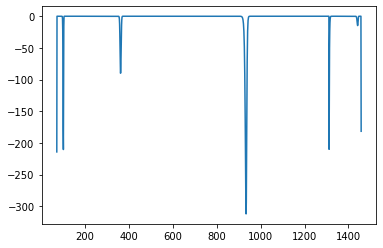

In [45]:
selected_frames = loaded_vidid_selected_frames[cur_vidid + ".txt"]
plt.plot(np.arange(selected_frames[0] - 1, selected_frames[-1] + 1), loss_arr[0].detach().cpu().numpy())

In [44]:
es_loss

tensor(3.3987, device='cuda:0', dtype=torch.float64)

In [35]:
video_id_boundary_frames[cur_vidid], loaded_vidid_selected_frames[cur_vidid + ".txt"], item_1[idx]

([75, 345, 1305, 1415, 1440, 1519],
 [73, 282, 455, 1312, 1434, 1458],
 tensor(1520, device='cuda:0', dtype=torch.int32))

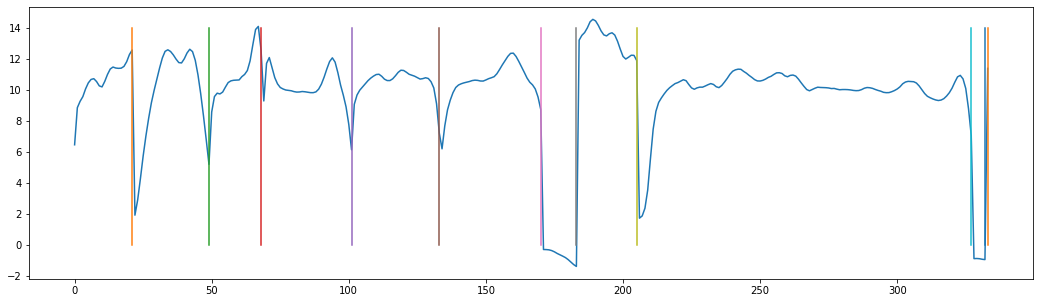

In [41]:
plt_arr = []
for i in range(item[1][idx].item()):
    plt_arr.append(cur_vid_feat[i,item[2][idx][i]].item()) 

fig = plt.figure(figsize=(18, 5))
plt.plot(np.arange(item[1][idx].item()), plt_arr)

for pivot in video_id_boundary_frames[cur_vidid]:
    plt.plot([pivot, pivot], [0, 14])

torch.Size([334, 334])

In [37]:
cur_features_shortened = cur_vid_feat[:item[1][idx]]
cur_features_shortened[:, item[2][idx][:item[1][idx]]].shape
for

torch.Size([334, 334])

In [26]:
item[2][idx][video_id_boundary_frames[cur_vidid][1]-6:video_id_boundary_frames[cur_vidid][1]+9]

tensor([47, 47, 47, 47, 47, 47, 47,  4,  4,  4,  4,  4,  4,  4,  4])

In [25]:
video_id_boundary_frames[cur_vidid][0]-6,video_id_boundary_frames[cur_vidid][0]+9

6

In [27]:
cur_vid_feat[video_id_boundary_frames[cur_vidid][1]-7:video_id_boundary_frames[cur_vidid][1]+9][:,[47,4]]

tensor([[ 1.0794, 13.3350],
        [ 1.0831, 13.5102],
        [ 1.1767, 13.7662],
        [ 1.3750, 14.0177],
        [ 1.7298, 14.1727],
        [ 2.1706, 14.0367],
        [ 2.7338, 13.4563],
        [ 4.5600, 12.1745],
        [ 7.8450, 10.3246],
        [11.0151,  8.3563],
        [13.4775,  6.6546],
        [14.1836,  5.2898],
        [11.2142,  4.2791],
        [ 5.9829,  3.5694],
        [ 2.3440,  2.9389],
        [ 0.7406,  2.3515]], device='cuda:0')

In [19]:
def add_frames_and_get_classification_value(model_output, count_list, video_ids_list, labels_all, p_criterion):
    new_selected_frames = {}
#     new_selected_frames_probs_values = {}
#     new_selected_frames_labels = {}
    
    labels_arr = []
    probs_arr = []
    
    for i, video_id in enumerate(video_ids_list):
        current_boundary_frames = boundaries_dict[video_id]
        current_video_logits = model_output[i].T
        current_video_count = count_list[i]
        current_selected_frames = loaded_vidid_selected_frames[video_id]
        labels = labels_all[i]
        cur_seg_start = 0
        for seg_num, ele in enumerate(current_boundary_frames):
            cur_seg_end = ele + 1
            total_seg_len = cur_seg_end - cur_seg_start
            per_frames_far_from_boundary = int(0.3 * total_seg_len)
            new_frames_start = cur_seg_start + per_frames_far_from_boundary
            new_frames_end = cur_seg_end - per_frames_far_from_boundary
            
            frames_added = list(range(new_frames_start, new_frames_end))
            frames_added.append(current_selected_frames[seg_num])
            frames_added = list(set(frames_added))
            frames_added.sort()
            new_selected_frames[video_id] = frames_added

            
            labels_seg = torch.stack([labels[current_selected_frames[seg_num]]] * len(frames_added))
            frames_added = torch.tensor(np.array(frames_added), dtype=torch.long, device=current_video_logits.device)
            prob_seg = current_video_logits[frames_added, :]
            
            labels_arr.append(labels_seg)
            probs_arr.append(prob_seg)
            
            cur_seg_start = cur_seg_end
            
    labels_arr = torch.cat(labels_arr)
    probs_arr = torch.cat(probs_arr)
    loss = p_criterion(probs_arr, labels_arr)
    return loss